   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slop

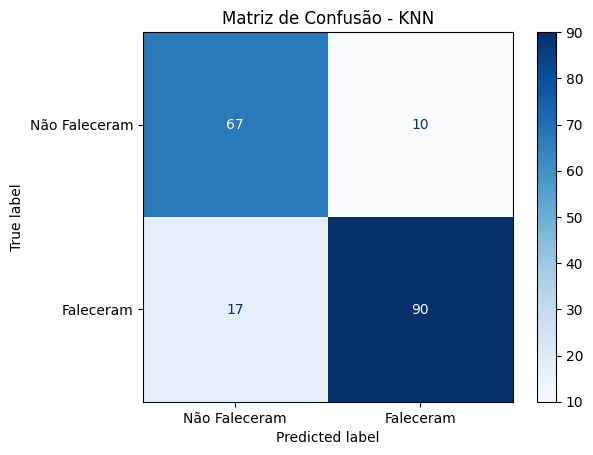

---- Naïve Bayes ----
Accuracy: 0.8587
F1 Score: 0.8738
Precision: 0.9091
Recall: 0.8411


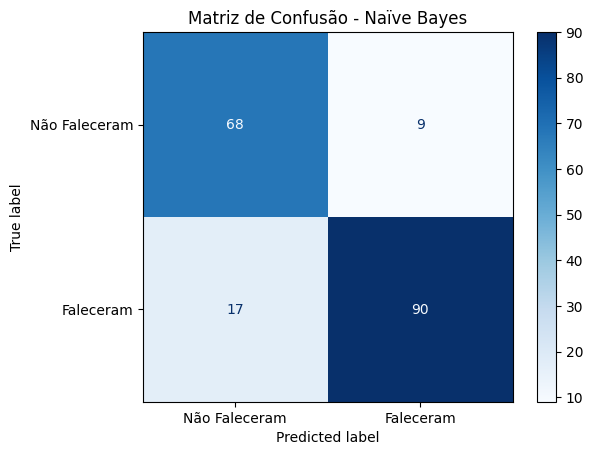

---- Árvore de Decisão ----
Accuracy: 0.8424
F1 Score: 0.8626
Precision: 0.8750
Recall: 0.8505


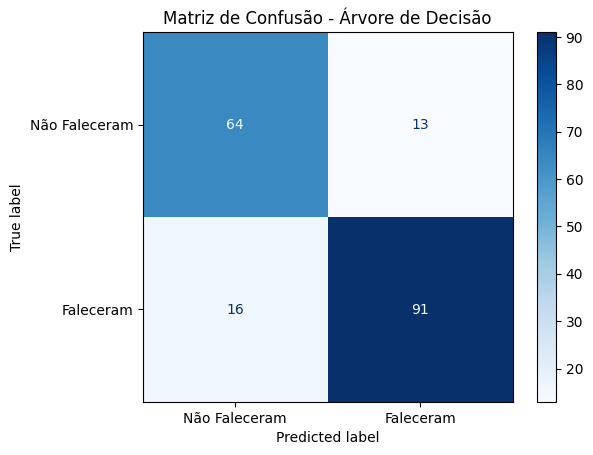

PermutationExplainer explainer: 185it [01:26,  2.10it/s]                                                                                                        


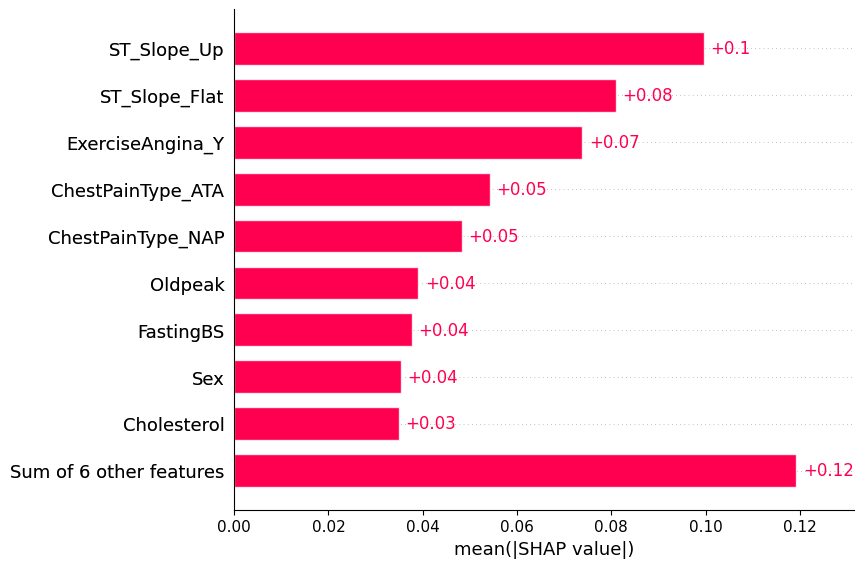

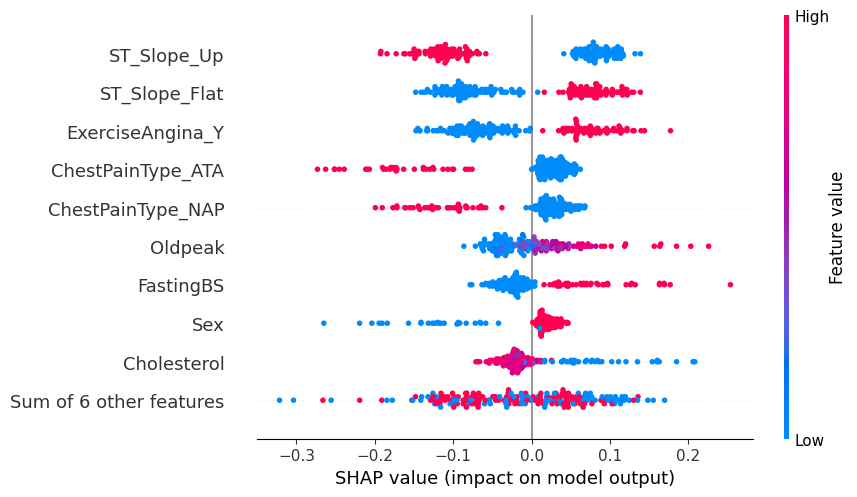


---- Comparação dos Modelos ----
KNN -> Acurácia: 0.8533 | F1 Score: 0.8696
Naïve Bayes -> Acurácia: 0.8587 | F1 Score: 0.8738
Árvore de Decisão -> Acurácia: 0.8424 | F1 Score: 0.8626


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import shap

# ----------------------------- Carregamento dos Dados -----------------------------
url = 'https://raw.githubusercontent.com/daltonexx/ML-Model-Interpretation/main/heart.csv'
df = pd.read_csv(url)

print(df.head())
print(df.isnull().sum())

# ----------------------------- Pré-processamento -----------------------------
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])  # M=1, F=0

df = pd.get_dummies(df, columns=['ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], drop_first=True)

X = df.drop(columns=['HeartDisease'])
Y = df['HeartDisease']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ----------------------------- KNN -----------------------------
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)
y_pred_knn = knn.predict(X_test)

print('---- KNN ----')
print(f'Accuracy: {accuracy_score(Y_test, y_pred_knn):.4f}')
print(f'F1 Score: {f1_score(Y_test, y_pred_knn):.4f}')
print(f'Precision: {precision_score(Y_test, y_pred_knn):.4f}')
print(f'Recall: {recall_score(Y_test, y_pred_knn):.4f}')

cm_knn = confusion_matrix(Y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Não Faleceram', 'Faleceram'])
disp_knn.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - KNN")
plt.show()

# ----------------------------- Naïve Bayes -----------------------------
nb = GaussianNB()
nb.fit(X_train, Y_train)
y_pred_nb = nb.predict(X_test)

print('---- Naïve Bayes ----')
print(f'Accuracy: {accuracy_score(Y_test, y_pred_nb):.4f}')
print(f'F1 Score: {f1_score(Y_test, y_pred_nb):.4f}')
print(f'Precision: {precision_score(Y_test, y_pred_nb):.4f}')
print(f'Recall: {recall_score(Y_test, y_pred_nb):.4f}')

cm_nb = confusion_matrix(Y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['Não Faleceram', 'Faleceram'])
disp_nb.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Naïve Bayes")
plt.show()

# ----------------------------- Árvore de Decisão -----------------------------
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, Y_train)
y_pred_dtree = dtree.predict(X_test)

print('---- Árvore de Decisão ----')
print(f'Accuracy: {accuracy_score(Y_test, y_pred_dtree):.4f}')
print(f'F1 Score: {f1_score(Y_test, y_pred_dtree):.4f}')
print(f'Precision: {precision_score(Y_test, y_pred_dtree):.4f}')
print(f'Recall: {recall_score(Y_test, y_pred_dtree):.4f}')

cm_dtree = confusion_matrix(Y_test, y_pred_dtree)
disp_dtree = ConfusionMatrixDisplay(confusion_matrix=cm_dtree, display_labels=['Não Faleceram', 'Faleceram'])
disp_dtree.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Árvore de Decisão")
plt.show()

# ----------------------------- SHAP para Interpretabilidade -----------------------------
def f(x): return knn.predict_proba(x)[:, 1]

# Conversão dos dados para float64 para funcionar com o SHAP
X_train_asfloat = X_train.astype(np.float64)
X_test_asfloat  = X_test.astype(np.float64)

explainer = shap.Explainer(
    lambda x: knn.predict_proba(x)[:, 1],
    X_train_asfloat,
    feature_names=X.columns  # <- força os nomes
)
shap_values = explainer(X_test_asfloat)
shap.plots.bar(shap_values)

plt.show()


# Exibe o gráfico de relevância para as features
shap.plots.beeswarm(shap_values)
plt.show()  # Garante que o gráfico será exibido


# ----------------------------- Comparação -----------------------------
print("\n---- Comparação dos Modelos ----")
models = ['KNN', 'Naïve Bayes', 'Árvore de Decisão']
accuracies = [
    accuracy_score(Y_test, y_pred_knn),
    accuracy_score(Y_test, y_pred_nb),
    accuracy_score(Y_test, y_pred_dtree)
]
f1_scores = [
    f1_score(Y_test, y_pred_knn),
    f1_score(Y_test, y_pred_nb),
    f1_score(Y_test, y_pred_dtree)
]
for model, acc, f1 in zip(models, accuracies, f1_scores):
    print(f"{model} -> Acurácia: {acc:.4f} | F1 Score: {f1:.4f}")
